In [1]:
# https://opendata.paris.fr/explore/dataset/quartier_paris/information/?disjunctive.c_ar
# https://opendata.paris.fr/explore/dataset/velib-disponibilite-en-temps-reel/information/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

%matplotlib inline

import pandas as pd

import geopandas
from shapely.geometry import Point, Polygon

pd.options.display.max_rows = 10

In [2]:
stations = geopandas.read_file("data/velib-disponibilite-en-temps-reel.geojson")

/usr/local/lib/python3.7/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 13
  self._schema = self.session.get_schema()
/usr/local/lib/python3.7/site-packages/geopandas/geodataframe.py:600: UserWarning: Empty field name at index 13
  for feature in features_lst:


In [3]:
stations[['is_installed', 'name', 'capacity', 'numbikesavailable', 'geometry']].head()

,is_installed,name,capacity,numbikesavailable,geometry
0,OUI,Toudouze - Clauzel,21.0,4.0,POINT (2.33736 48.87930)
1,OUI,Benjamin Godard - Victor Hugo,35.0,NaN,POINT (2.27572 48.86598)
2,OUI,Harpe -numbikesavailable Saint-Germain,45.0,29.0,POINT (2.34367 48.85152)
3,OUI,Jourdan - Stade Charléty,60.0,0.0,POINT (2.34334 48.81943)
4,OUI,Messine - Place Du Pérou,12.0,6.0,POINT (2.31551 48.87545)


In [4]:
quartiers = geopandas.read_file("data/quartier_paris.geojson")

In [5]:
quartiers.head()

,c_quinsee,surface,c_qu,c_ar,l_qu,perimetre,n_sq_qu,n_sq_ar,geometry
0,7510602,7.161484e+05,22,6,Odéon,3516.314464,750000022,750000006,"POLYGON ((2.33699 48.85290, 2.33894 48.85242, ..."
1,7510504,4.331978e+05,20,5,Sorbonne,2892.944068,750000020,750000005,"POLYGON ((2.34924 48.84452, 2.34888 48.84449, ..."
2,7511303,2.231506e+06,51,13,Maison-Blanche,6814.373288,750000051,750000013,"POLYGON ((2.34912 48.82960, 2.34954 48.82955, ..."
3,7511403,1.345774e+06,55,14,Petit-Montrouge,5490.636672,750000055,750000014,"POLYGON ((2.32914 48.83413, 2.33153 48.83324, ..."
4,7511701,1.465071e+06,65,17,Ternes,5264.597082,750000065,750000017,"POLYGON ((2.29504 48.87378, 2.29504 48.87378, ..."


In [6]:
type(stations)

geopandas.geodataframe.GeoDataFrame

In [7]:
type(stations.geometry)

geopandas.geoseries.GeoSeries

In [8]:
type(stations.geometry[0])

shapely.geometry.point.Point

In [9]:
stations = stations[stations['is_installed'] == 'OUI'].copy()

<AxesSubplot:>

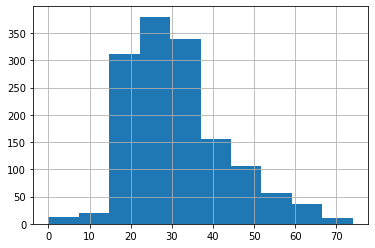

In [10]:
stations['capacity'].hist()

In [11]:
# EPSG:4326 (WGS84) is geographic CRS and its unit is degree. The key message here is "Geometry is in a geographic CRS". You don't get a warning when using EPSG:4328 because it is not geographic, but it is geocentric and its unit is meter.
print(quartiers.crs)
quartiers_3857 = quartiers.to_crs(3857)
# areas km²
areas = quartiers_3857.geometry.area / 1000**2

pd.set_option('display.float_format', lambda x: '%.10f' % x)
print(areas)
print(areas.describe())
pd.reset_option('display.float_format')

epsg:4326
0    1.6526629648
1    0.9997394236
2    5.1447955444
3    3.1031380968
4    3.3852707482
         ...     
75   7.1297410333
76   0.5625015680
77   1.7571081612
78   1.1562732092
79   1.6760786903
Length: 80, dtype: float64
count   80.0000000000
mean     3.0406412751
std      3.0735752957
min      0.4342335545
25%      1.1483612278
50%      2.1436235713
75%      3.3918995639
max     16.6159388813
dtype: float64


In [12]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="this_is_a_test")
location = geolocator.geocode("Notre Dame Paris")
notre_dame = Point(location.longitude, location.latitude)
print(notre_dame)

POINT (2.3500501225000026 48.85293705)


In [13]:
import pyproj
proj = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)

x1, y1 = (2.35005149954546, 48.85293695)
x2, y2 = proj.transform(x1, y1)
notre_dame_3857 = Point(x2, y2)
print(notre_dame_3857)

POINT (261606.5362673696 6249944.611709531)


In [14]:
distance = stations.to_crs(3857).geometry.distance(notre_dame_3857)
pd.set_option('display.float_format', lambda x: '%.10f' % x)
print(distance)
print(type(distance))
print(distance.describe())
pd.reset_option('display.float_format')

0      4678.9793056718
1      8563.3860336711
2       749.7715267154
3      5716.1985606057
4      5412.7126608041
             ...      
1432   7897.9834365065
1433   6479.6376011011
1434   6868.7811517864
1435   4669.8514491067
1436   4187.1026408723
Length: 1430, dtype: float64
<class 'pandas.core.series.Series'>
count    1430.0000000000
mean     7062.3353039333
std      3828.3866349933
min       176.7452107424
25%      4311.5138924256
50%      6496.5968704608
75%      9170.2316248958
max     22233.7708904375
dtype: float64


In [15]:
quartiers.contains(notre_dame)

0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [16]:
quartiers[quartiers['l_qu'] == 'Notre-Dame'].contains(notre_dame)

47    True
dtype: bool

In [17]:
quartiers[quartiers['l_qu'].str.contains("Notre-Dame")]

,c_quinsee,surface,c_qu,c_ar,l_qu,perimetre,n_sq_qu,n_sq_ar,geometry
6,7510603,861307.037826,23,6,Notre-Dame-des-Champs,4559.989773,750000023,750000006,"POLYGON ((2.33676 48.84013, 2.33673 48.83965, ..."
47,7510404,378252.153674,16,4,Notre-Dame,3283.163371,750000016,750000004,"POLYGON ((2.36131 48.84858, 2.36151 48.84823, ..."


In [18]:
quartiers[quartiers['l_qu'].str.contains("Notre-Dame")].contains(notre_dame)

6     False
47     True
dtype: bool

In [19]:
quartiers[quartiers.contains(notre_dame)]

,c_quinsee,surface,c_qu,c_ar,l_qu,perimetre,n_sq_qu,n_sq_ar,geometry
47,7510404,378252.153674,16,4,Notre-Dame,3283.163371,750000016,750000004,"POLYGON ((2.36131 48.84858, 2.36151 48.84823, ..."


<AxesSubplot:>

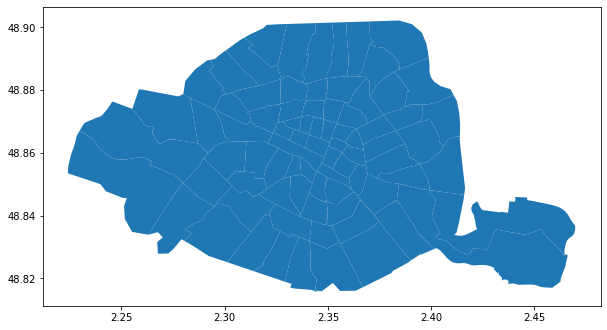

In [20]:
quartiers.plot(figsize=(10, 10))

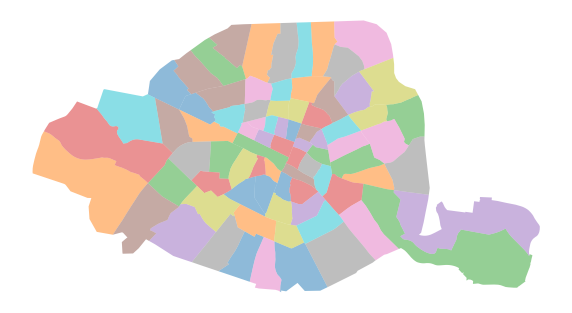

In [21]:
ax = quartiers.plot(figsize=(10, 10), cmap='tab10', alpha=0.5)
ax.set_axis_off()

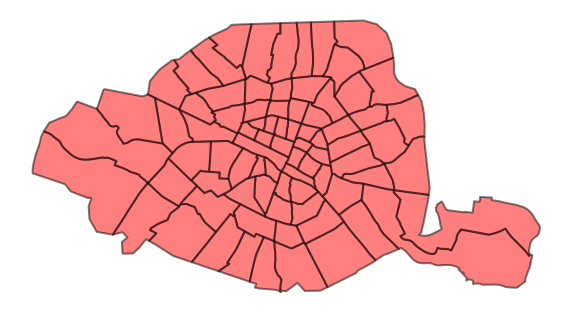

In [22]:
ax = quartiers.plot(figsize=(10, 10), edgecolor='k',
                    facecolor='r', alpha=0.5, linewidth=2)
ax.set_axis_off()

<AxesSubplot:>

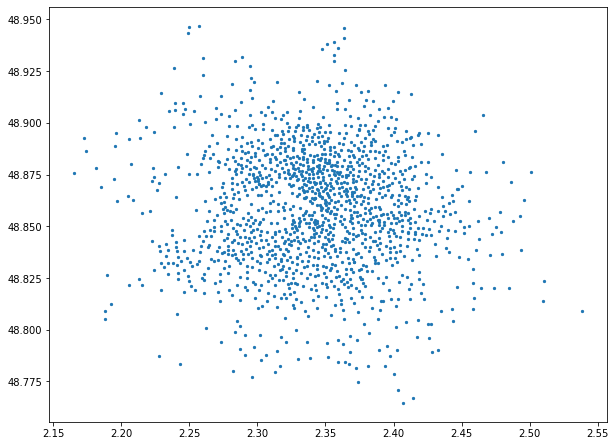

In [23]:
stations.plot(markersize=5, figsize=(10, 10))

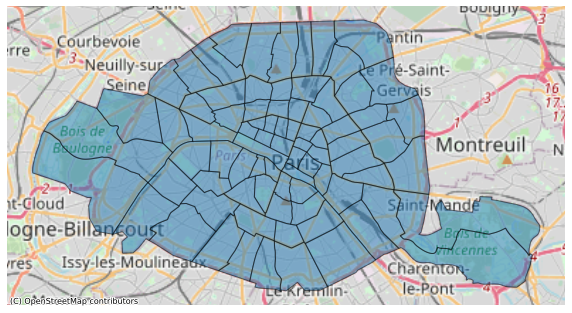

In [24]:
import contextily as ctx
ax = quartiers.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=11, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

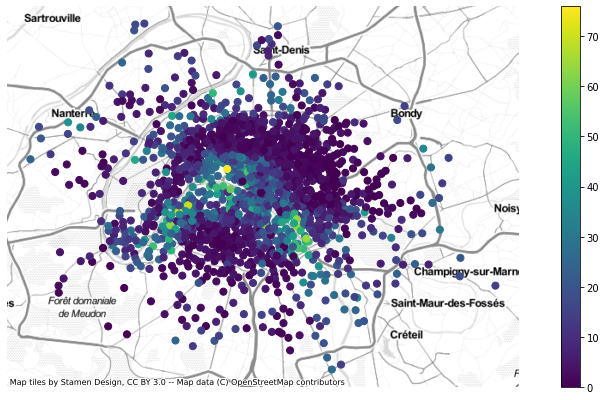

In [25]:
ax = stations.to_crs(epsg=3857).plot(
    column='numbikesavailable', markersize=50, legend=True, figsize=(15, 7))
ctx.add_basemap(ax, zoom=11,source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

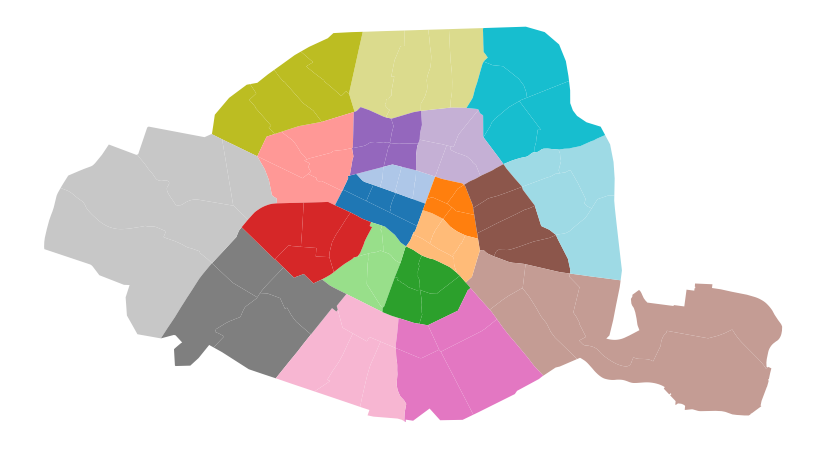

In [26]:
ax = quartiers.plot(column='n_sq_ar', categorical=True, cmap='tab20', figsize=(15, 8))
ax.set_axis_off()

In [27]:
print(stations.sindex.valid_query_predicates)
stations_x_quartier = geopandas.sjoin(stations,
                           quartiers[['l_qu', 'geometry']].copy(),
                           predicate='within')

{'intersects', 'crosses', 'touches', 'covers', 'overlaps', 'contains', 'within', 'covered_by', None, 'contains_properly'}


In [28]:
stations_x_quartier.head()

,name,stationcode,ebike,mechanical,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning,,geometry,index_right,l_qu
0,Toudouze - Clauzel,9020,4,0,2022-02-10T12:27:17+01:00,4.0,17,21.0,OUI,OUI,Paris,OUI,NaN,POINT (2.33736 48.87930),52,Saint-Georges
79,Douai - Bruxelles,9038,0,0,2022-02-10T12:31:05+01:00,0.0,27,27.0,OUI,OUI,Paris,OUI,NaN,POINT (2.33084 48.88321),52,Saint-Georges
103,Moncey - Blanche,9028,2,1,2022-02-10T12:30:03+01:00,3.0,13,17.0,OUI,OUI,Paris,OUI,NaN,POINT (2.33108 48.88007),52,Saint-Georges
277,Saint Georges - d'Aumale,9021,4,0,2022-02-10T12:26:43+01:00,4.0,16,23.0,OUI,OUI,Paris,OUI,NaN,POINT (2.33743 48.87779),52,Saint-Georges
531,Jean-Baptiste Pigalle - La Bruyere,9026,0,2,2022-02-10T12:28:07+01:00,2.0,13,17.0,OUI,OUI,Paris,OUI,NaN,POINT (2.33371 48.87940),52,Saint-Georges


In [29]:
stations_x_quartier_counts = stations_x_quartier.groupby('l_qu').size()
print(stations_x_quartier_counts)

l_qu
Amérique           16
Archives            3
Arsenal             7
Arts-et-Métiers     4
Auteuil            21
                   ..
Sorbonne           11
Ternes             17
Val-de-Grâce        7
Villette           14
Vivienne            7
Length: 80, dtype: int64


In [30]:
quartiers_stations_counts = quartiers.merge(stations_x_quartier_counts.reset_index(name='nb_stations'))

In [31]:
quartiers_stations_counts.head()

,c_quinsee,surface,c_qu,c_ar,l_qu,perimetre,n_sq_qu,n_sq_ar,geometry,nb_stations
0,7510602,7.161484e+05,22,6,Odéon,3516.314464,750000022,750000006,"POLYGON ((2.33699 48.85290, 2.33894 48.85242, ...",8
1,7510504,4.331978e+05,20,5,Sorbonne,2892.944068,750000020,750000005,"POLYGON ((2.34924 48.84452, 2.34888 48.84449, ...",11
2,7511303,2.231506e+06,51,13,Maison-Blanche,6814.373288,750000051,750000013,"POLYGON ((2.34912 48.82960, 2.34954 48.82955, ...",17
3,7511403,1.345774e+06,55,14,Petit-Montrouge,5490.636672,750000055,750000014,"POLYGON ((2.32914 48.83413, 2.33153 48.83324, ...",14
4,7511701,1.465071e+06,65,17,Ternes,5264.597082,750000065,750000017,"POLYGON ((2.29504 48.87378, 2.29504 48.87378, ...",17


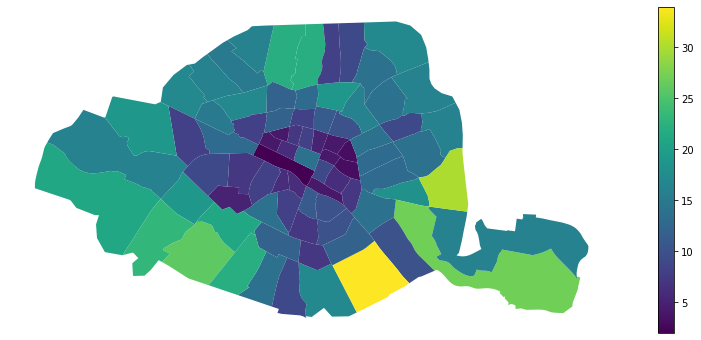

In [32]:
ax = quartiers_stations_counts.plot(column='nb_stations', figsize=(15, 6), legend=True)
ax.set_axis_off()

In [33]:
quartiers_stations_counts = quartiers_stations_counts.to_crs(3857)
quartiers_stations_counts['number_bike_stations_relative'] = (
    quartiers_stations_counts['nb_stations'] / (quartiers_stations_counts.geometry.area / 1000**2))

In [34]:
quartiers_stations_counts.head()

,c_quinsee,surface,c_qu,c_ar,l_qu,perimetre,n_sq_qu,n_sq_ar,geometry,nb_stations,number_bike_stations_relative
0,7510602,7.161484e+05,22,6,Odéon,3516.314464,750000022,750000006,"POLYGON ((260152.388 6249938.692, 260369.768 6...",8,4.840672
1,7510504,4.331978e+05,20,5,Sorbonne,2892.944068,750000020,750000005,"POLYGON ((261516.706 6248520.128, 261476.634 6...",11,11.002867
2,7511303,2.231506e+06,51,13,Maison-Blanche,6814.373288,750000051,750000013,"POLYGON ((261502.287 6245996.849, 261549.290 6...",17,3.304310
3,7511403,1.345774e+06,55,14,Petit-Montrouge,5490.636672,750000055,750000014,"POLYGON ((259278.315 6246763.082, 259545.039 6...",14,4.511562
4,7511701,1.465071e+06,65,17,Ternes,5264.597082,750000065,750000017,"POLYGON ((255482.642 6253471.354, 255482.639 6...",17,5.021755


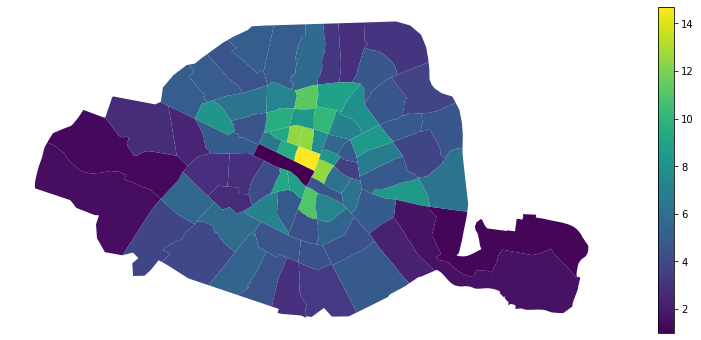

In [35]:
ax = quartiers_stations_counts.plot(column='number_bike_stations_relative',
                    figsize=(15, 6), legend=True)
ax.set_axis_off()

In [69]:
import ipyleaflet
import random
m = ipyleaflet.Map(center = [48.8566, 2.3429], zoom = 12)

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }

layer = ipyleaflet.GeoJSON(
    data=quartiers.__geo_interface__,
    style={
        'opacity': 1, 'dashArray': '5', 'fillOpacity': 0.3, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    },
    style_callback=random_color
)
m.add_layer(layer)
m


Map(center=[48.8566, 2.3429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [68]:

from ipyleaflet import Map, basemaps, basemap_to_tiles
from ipywidgets import Layout

m = Map(
    basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2022-02-10"),
    center=(52.204793, 360.121558),
    zoom=4,
    layout=Layout(width='80%', height='500px')
)

m

Map(center=[52.204793, 360.121558], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…